In [1]:
%matplotlib inline
import sys
import os
import requests
import json
import pandas
import matplotlib.pyplot

In [2]:
url = "https://desc-tom.lbl.gov"
# url = "https://desc-tom-rknop-dev.lbl.gov"

# Somehow you need to set the "username" and "password" variables.
# Do NOT hardcode the password into any code that will be world
# readable.  You can use the python input statement, or, as I do
# here, read the password from a file that is only readable by
# you.  (This isn't perfect, but it's better than having the
# password sit around in a world readable file.)
username = "rknop"
with open( os.path.join( os.getenv("HOME"), "secrets", "tom_rknop_passwd" ) ) as ifp:
    password = ifp.readline().strip()

In [3]:
# This gets you a python requests object named rqs
# that is logged into the TOM.  It uses the username
# and password determined in the previous cell.

rqs = requests.session()
rqs.get( f'{url}/accounts/login/' )
res = rqs.post( f'{url}/accounts/login/',
                data={ "username": username,
                       "password": password,
                       "csrfmiddlewaretoken": rqs.cookies['csrftoken'] } )
if res.status_code != 200:
    raise RuntimeError( f"Failed to log in; http status: {res.status_code}" )
if 'Please enter a correct' in res.text:
    raise RuntimeError( "Failed to log in.  I think.  Put in a debug break and look at res.text" )
rqs.headers.update( { 'X-CSRFToken': rqs.cookies['csrftoken'] } )

In [4]:
# This function effectively pushes a cursor.execute() through
# the web API, returning the corresponding cursor.fetchrows()
#
# You can pass multiple queries, in which case query should
# be a list of strings and subdict should be a list of dicts.
# You will get back the rows from the last query.
#
# Depends on global variable rqs
def run_query( query, subdict=None ):
    if isinstance( query, list ):
        subdict = [ {} for i in range(len(query)) ] if subdict is None else subdict
        sendjson = { 'queries': query, 'subdicts': subdict }
    else:
        subdict = {} if subdict is None else subdict
        sendjson = { 'query': query, 'subdict': subdict }
    result = rqs.post( f'{url}/db/runsqlquery/', json=sendjson )
    if ( result.status_code != 200 ):
        raise RuntimeError( f"Got http status {result.status_code}" )
    data = json.loads( result.text )
    if ( 'status' in data ) and ( data['status'] == 'error' ):
        sys.stderr.write( f"ERROR: {data['error']}" )
        return []
    elif ( 'status' not in data ) or ( data['status'] != 'ok' ):
        raise RuntimeError( f"Got unexpected response: {data}" )
    return data['rows']


In [5]:
# Example: look at the contents of the elasticc_gentypeofclassid table
# (That's the table that you would use if you have a gentype in order
# to figure out what classId a broker should supply for it.)
#
query = 'SELECT * FROM elasticc_gentypeofclassid'
rows = run_query( query )
print( f'classId   gentype    description' )
print( '---------------------------------' )
for row in rows:
    print( f'{row["classId"]:7d}   '
           f'{"None" if row["gentype"] is None else str(row["gentype"]):>7s}    '
           f'{row["description"]}' )

classId   gentype    description
---------------------------------
      0      None    Static/Other
      1      None    Non-Recurring
     10      None    Non-Recurring/Other
     11      None    SN-like
    110      None    SN-like/Other
    111        10    Ia
    112        20    Ib/c
    112        21    Ib/c
    112        25    Ib/c
    112        26    Ib/c
    112        27    Ib/c
    113        30    II
    113        31    II
    113        32    II
    113        35    II
    113        36    II
    113        37    II
    114        12    Iax
    115        11    91bg
     12      None    Fast
    120      None    Fast/Other
    121        50    KN
    121        51    KN
    122        82    M-dwarf Flare
    123        84    Dwarf Nova
    124        87    uLens
    124        88    uLens
    124        89    uLens
     13      None    Long
    130      None    Long/Other
    131        40    SLSN
    132        42    TDE
    133        45    ILOT
    134        46    

In [6]:
# example: look at the contents of the classidofgentype table
# (That's the table you would use given a classId from a broker
# to figure out which gentypes (there could be more than one)
# correspond to it.)
#
query = 'SELECT * FROM elasticc_classidofgentype'
rows = run_query( query )
print( f'classId   gentype    exactmatch categorymatch description' )
print( '--------------------------------------------------------------' )
for row in rows:
    print( f'{row["classId"]:7d}   '
           f'{"None" if row["gentype"] is None else str(row["gentype"]):>7s}    '
           f'{str(row["exactmatch"]):10s} '
           f'{str(row["categorymatch"]):13s} '
           f'{row["description"]}' )

classId   gentype    exactmatch categorymatch description
--------------------------------------------------------------
      1        10    False      False         Non-Recurring
      1        20    False      False         Non-Recurring
      1        21    False      False         Non-Recurring
      1        25    False      False         Non-Recurring
      1        26    False      False         Non-Recurring
      1        27    False      False         Non-Recurring
      1        30    False      False         Non-Recurring
      1        31    False      False         Non-Recurring
      1        32    False      False         Non-Recurring
      1        35    False      False         Non-Recurring
      1        36    False      False         Non-Recurring
      1        37    False      False         Non-Recurring
      1        12    False      False         Non-Recurring
      1        11    False      False         Non-Recurring
      1        50    False      False  

In [11]:
# Example: we want to look at a SNIa lightcurve.  Pick out a SNIa from the truth table
# that has at least 5 detections that have already been sent to brokers.
# NOTE: this requires your database account to be in the "elasticc admin" group; otherwise
# you won't have read access to the truth table.
query = ( 'SELECT "diaObjectId",ndets FROM '
          ' ( SELECT ot."diaObjectId",COUNT(s."diaSourceId") AS ndets FROM elasticc_diaobjecttruth ot '
          '   INNER JOIN elasticc_diasource s ON ot."diaObjectId"=s."diaObjectId" '
          '   INNER JOIN elasticc_diaalert a ON s."diaSourceId"=a."diaSourceId" '
          '   WHERE a."alertSentTimestamp" IS NOT NULL '
          '     AND ot.gentype=10 '
          '   GROUP BY ot."diaObjectId" ) subq '
          '   WHERE ndets > 5 LIMIT 10 ' )
objlist = run_query( query )
objlist

[{'diaObjectId': 1000674, 'ndets': 6},
 {'diaObjectId': 1002647, 'ndets': 14},
 {'diaObjectId': 1002842, 'ndets': 10},
 {'diaObjectId': 1003312, 'ndets': 13},
 {'diaObjectId': 1004497, 'ndets': 17},
 {'diaObjectId': 1004713, 'ndets': 7},
 {'diaObjectId': 1005738, 'ndets': 6},
 {'diaObjectId': 1005956, 'ndets': 9},
 {'diaObjectId': 1006052, 'ndets': 9},
 {'diaObjectId': 1007116, 'ndets': 7}]

In [12]:
# I like the look of the 4th one I got when I ran this query so let's get that one's lightcurve.
#
# Get the lightcurve that would have been in the most recent alert that's been sent.  To do that:
# * Find the latest alert that has alertSentTimestamp that's not NULL.
# * Find the first alert for that object
# * Return everything in diaForcedSource that is between (first alert - 30 days) and (latest alert)
#
#...I hope I did that right

objid = objlist[3]['diaObjectId']
query = ( 'SELECT "midPointTai","filterName","psFlux","psFluxErr" FROM elasticc_diaforcedsource '
          'WHERE "diaObjectId"=%(objid)s '
          'AND "midPointTai" >= ( SELECT "midPointTai"-30 FROM elasticc_diasource '
          '                        WHERE "diaObjectId"=%(objid)s '
          '                        ORDER BY "midPointTai" LIMIT 1 ) '
          'AND "midPointTai" <= ( SELECT "midPointTai" FROM elasticc_diasource s '
          '                       INNER JOIN elasticc_diaalert a ON s."diaSourceId"=a."diaSourceId" '
          '                       WHERE a."alertSentTimestamp" IS NOT NULL AND s."diaObjectId"=%(objid)s'
          '                       ORDER BY s."midPointTai" DESC LIMIT 1 ) ' )
rows = run_query( query, { 'objid': objid } )
print( f"Got {len(rows)} forced photometry points." )

Got 25 forced photometry points.


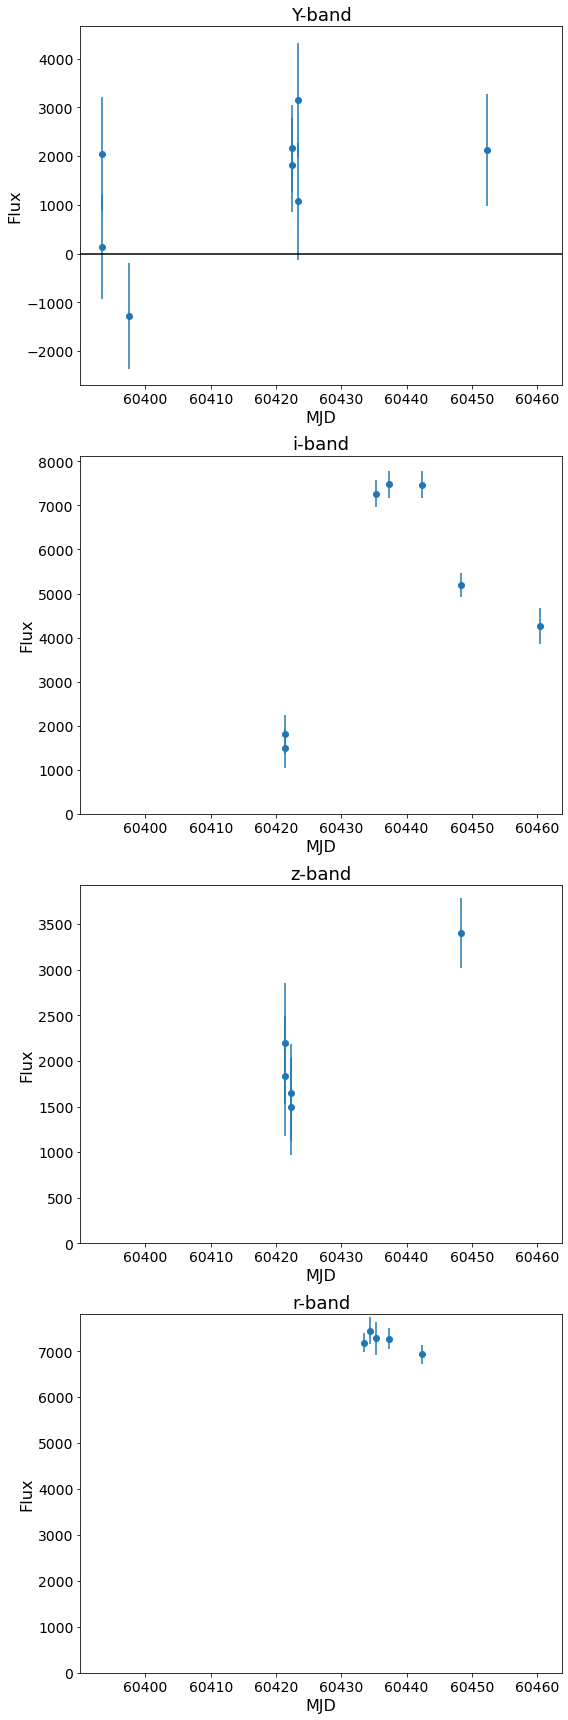

In [13]:
# Plot!
df = pandas.DataFrame( rows )
filters = df['filterName'].unique()
mint = df['midPointTai'].min()
maxt = df['midPointTai'].max()
dt = maxt-mint
mint -= 0.05*dt
maxt += 0.05*dt
fig = matplotlib.pyplot.figure( figsize=(8,6*len(filters)), tight_layout=True )
for i, filter in enumerate(filters):
    subdf = df[ df['filterName'] == filter ]
    ax = fig.add_subplot( len(filters), 1, i+1 )
    ax.errorbar( subdf['midPointTai'], subdf['psFlux'], subdf['psFluxErr'], linestyle='None', marker='o' )
    ax.set_title( f'{filter}-band', fontsize=18 )
    ax.set_xlabel( 'MJD', fontsize=16 )
    ax.set_ylabel( 'Flux', fontsize=16 )
    ax.tick_params( 'both', labelsize=14 )
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
        ax.set_ylim( 0, ymax )
    else:
        ax.axhline( color='black' )
    ax.set_xlim( mint, maxt )
fig.show()
    

In [14]:
# Gratuitous multiple query example

queries = [ 'SELECT a."alertId",a."diaSourceId",a."diaObjectId",s."diaObjectId" AS indirect_object '
            'INTO TEMP TABLE gratuitous_table '
            'FROM elasticc_diaalert a'
            '  INNER JOIN elasticc_diasource s ON a."diaSourceId"=s."diaSourceId" '
            'LIMIT 100 '
           ,
            'SELECT * FROM pg_temp.gratuitous_table' ]
rows = run_query( queries )
print( "alertId          diaSourceId       diaObjectId      indirect_object\n"
       "--------------------------------------------------------------------------" )
for row in rows:
    print( f"{row['alertId']:16d} {row['diaSourceId']:16d} {row['diaObjectId']:16d} {row['indirect_object']:16d}" )

alertId          diaSourceId       diaObjectId      indirect_object
--------------------------------------------------------------------------
    158754350001     158754350001         79377175         79377175
    207145434138     207145434138        103572717        103572717
     31889362036      31889362036         15944681         15944681
    106948878004     106948878004         53474439         53474439
     97574872002      97574872002         48787436         48787436
     89040244024      89040244024         44520122         44520122
    160378262120     160378262120         80189131         80189131
    112167490031     112167490031         56083745         56083745
     10975530036      10975530036          5487765          5487765
    110270482034     110270482034         55135241         55135241
    141400738030     141400738030         70700369         70700369
    189852304038     189852304038         94926152         94926152
    223176860006     223176860006        